<a href="https://colab.research.google.com/github/b-hill/cop4630/blob/master/hw4_p3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Edits

I decided to exchange the VGG16 model for ResNet. This was primartily because I'm implementing ResNet for a pose estimation app for senior design and i would like to see how the so called king of image classification models fairs in another context.  

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-21 21:59:38--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 2404:6800:4008:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  68.6MB/s    in 1.0s    

2020-04-21 21:59:39 (68.6 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with MobileNet convolution base and custom densely connected layers

### Load the convolutional base

In [4]:
from keras.applications.resnet import ResNet50

conv_base = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Using TensorFlow backend.


94773248/94765736 [==============================] - 8s 0us/step


### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
# edit classifier 128 -> 64 nodes and also change activation relu -> tanh
model.add(layers.Dense(64, activation='tanh')) 
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                3276864   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 26,864,641
Trainable params: 3,276,929
Non-trainable params: 23,587,712
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 30s 303ms/step - loss: 0.4090 - acc: 0.8060 - val_loss: 0.8124 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 20s 201ms/step - loss: 0.2819 - acc: 0.8825 - val_loss: 1.0698 - val_acc: 0.5000
Epoch 3/30
100/100 [==============================] - 20s 203ms/step - loss: 0.2517 - acc: 0.8860 - val_loss: 0.8222 - val_acc: 0.5000
Epoch 4/30
100/100 [==============================] - 21s 205ms/step - loss: 0.2158 - acc: 0.9100 - val_loss: 1.0951 - val_acc: 0.5000
Epoch 5/30
100/100 [==============================] - 20s 202ms/step - loss: 0.2282 - acc: 0.9040 - val_loss: 1.1931 - val_acc: 0.5000
Epoch 6/30
100/100 [==============================] - 20s 203ms/step - loss: 0.2215 - acc: 0.8990 - val_loss: 1.0310 - val_acc: 0.5000
Epoch 7/30
100/100 [==============================] - 20s 202ms/step - loss: 0.1997 - acc: 0.9135 - val_lo

## Display curves of loss and accuracy during training

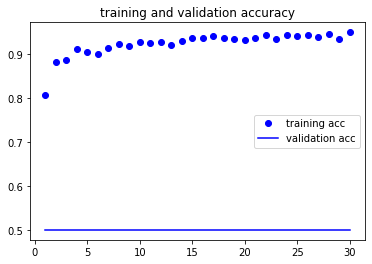

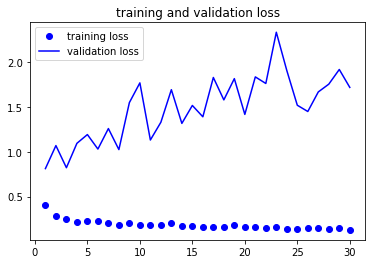

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'conv5_block2_2_conv': ## change frozen layer
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [11]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 26s 265ms/step - loss: 0.1275 - acc: 0.9515 - val_loss: 1.4001 - val_acc: 0.5000
Epoch 2/100
100/100 [==============================] - 21s 210ms/step - loss: 0.1428 - acc: 0.9360 - val_loss: 1.8794 - val_acc: 0.5000
Epoch 3/100
100/100 [==============================] - 21s 211ms/step - loss: 0.1389 - acc: 0.9440 - val_loss: 1.7277 - val_acc: 0.5000
Epoch 4/100
100/100 [==============================] - 21s 211ms/step - loss: 0.1280 - acc: 0.9490 - val_loss: 1.7137 - val_acc: 0.4860
Epoch 5/100
100/100 [==============================] - 21s 210ms/step - loss: 0.1163 - acc: 0.9525 - val_loss: 1.2871 - val_acc: 0.5020
Epoch 6/100
100/100 [==============================] - 21s 210ms/step - loss: 0.1317 - acc: 0.9520 - val_loss: 0.7709 - val_acc: 0.5620
Epoch 7/100
100/100 [==============================] - 21s 208ms/step - loss: 0.1221 - acc: 0.9560 - val_loss: 1.2751 - val_acc: 0.7010
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

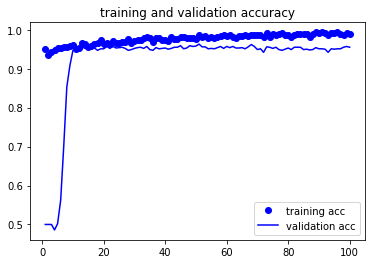

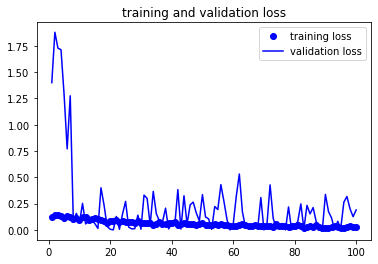

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

This looks like overfitting. I should try  adding dropout for the densely connected layer.

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [14]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.0010690323542803526
Validation accuracy: 0.9549999833106995


## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)